**Please view the notebook on nbviewer to render the plots correctly.**

In [59]:
#libraries 
import pandas as pd
import gzip
from tqdm import tqdm

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse
import numpy as np
import pandas as pd


from bokeh.plotting import figure, output_notebook, show,output_file,gridplot
from bokeh.models import DatetimeTickFormatter,HoverTool,Span

import json
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
plt.style.use(['seaborn-whitegrid'])

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
plotcount = 0

In [2]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


## 1-Metadata:
Before taking a closer look at the ratings we will consider the metadata dataset. In this dataset we will amongst other things find information about title, price, description, and the products each product is related to. In order to examine the metadata, we load part of it into a data frame to be able to see it and do some descriptive statistics. 

In [4]:

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

meta = getDF('meta_Electronics.json.gz')
meta.head(5)

asin                                              imUrl  \
0  0132793040  http://ecx.images-amazon.com/images/I/31JIPhp%...   
1  0321732944  http://ecx.images-amazon.com/images/I/31uogm6Y...   
2  0439886341  http://ecx.images-amazon.com/images/I/51k0qa8f...   
3  0511189877  http://ecx.images-amazon.com/images/I/41HaAhbv...   
4  0528881469  http://ecx.images-amazon.com/images/I/51FnRkJq...   

                                         description  \
0  The Kelby Training DVD Mastering Blend Modes i...   
1                                                NaN   
2                    Digital Organizer and Messenger   
3  The CLIKR-5 UR5U-8780L remote control is desig...   
4  Like its award-winning predecessor, the Intell...   

                                          categories  \
0  [[Electronics, Computers & Accessories, Cables...   
1  [[Electronics, Computers & Accessories, Cables...   
2  [[Electronics, Computers & Accessories, PDAs, ...   
3  [[Electronics, Accessories & Supplies, Audio &...   
4  [[Electronics, GPS & Navigation, Vehicle GPS, ...   

                                               title   price  \
0  Kelby Training DVD: Mastering Blend Modes in A...     NaN   
1  Kelby Training DVD: Adobe Photoshop CS5 Crash ...     NaN   
2                    Digital Organizer and Messenger    8.15   
3  CLIKR-5 Time Warner Cable Remote Control UR5U-...   23.36   
4  Rand McNally 528881469 7-inch Intelliroute TND...  299.99   

                 salesRank                                            related  \
0                      NaN                                                NaN   
1                      NaN                                                NaN   
2  {'Electronics': 144944}  {'also_viewed': ['0545016266', 'B009ECM8QY', '...   
3                      NaN  {'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...   
4                      NaN  {'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...   

  brand  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

We see that we have nine columns in total:

- asin (This is the id of the product)
- brand
- categories (list of different categories, that the product belongs to)
- description (can be very long, e.g. a book summary)
- imUrl (URL to picture of the product)
- price
- related (dictionary of different features concerning related products. In particular: also_bpught, also_viewed, boght_together)
- salesRank (ranking of product within their category based on how much it sells)
- title

Most of these things are observable from the dataset, but some things needed a seperate explaination such as the salesRank, which we found on Amazon.com.

We are interested only in a subset of variables, namely the code of the products (asin) , their titles, their sub-categories, their sales ranks, their prices.

In [5]:
#extract the sub-categories
meta['sub_category_1']=list(map(lambda x:x[0][1],meta.categories))
meta['sub_category_0']=list(map(lambda x:x[0][0],meta.categories))


In [12]:
#extract the sales category (just in case it is no the same as the main category)and the sales rank 
sales_cat=[]
sales_rank=[]
for i in range(len(meta)):
    if (type(meta.salesRank[i])==dict) :
        if(len(meta.salesRank[i])>0):
            sales_cat.append(list(meta.salesRank[i].keys())[0])
            sales_rank.append(list(meta.salesRank[i].values())[0])
        else:
            sales_cat.append('unkown')
            sales_rank.append(None)
    else:
        sales_cat.append('unkown')
        sales_rank.append(None)

In [13]:
meta['sales_category']=sales_cat
meta['sales_rank']=sales_rank

In [14]:
meta.head(1)

asin                                              imUrl  \
0  0132793040  http://ecx.images-amazon.com/images/I/31JIPhp%...   

                                         description  \
0  The Kelby Training DVD Mastering Blend Modes i...   

                                          categories  \
0  [[Electronics, Computers & Accessories, Cables...   

                                               title  price salesRank related  \
0  Kelby Training DVD: Mastering Blend Modes in A...    NaN       NaN     NaN   

  brand           sub_category_1 sub_category_0 sales_category  sales_rank  
0   NaN  Computers & Accessories    Electronics         unkown         NaN

In [21]:
#extract only the metadata we need 
meta_use =meta [['asin','title','price','sub_category_1','sales_rank']]

In [22]:
meta_use.head(10)

asin                                              title   price  \
0  0132793040  Kelby Training DVD: Mastering Blend Modes in A...     NaN   
1  0321732944  Kelby Training DVD: Adobe Photoshop CS5 Crash ...     NaN   
2  0439886341                    Digital Organizer and Messenger    8.15   
3  0511189877  CLIKR-5 Time Warner Cable Remote Control UR5U-...   23.36   
4  0528881469  Rand McNally 528881469 7-inch Intelliroute TND...  299.99   
5  0558835155  Polaroid Pbm2200 PC / Gaming Stereo Headphones...   13.95   
6  0594012015  Barnes &amp; Noble NOOK Power Kit in Carbon BN...   32.10   
7  0594017580          Jonathan Adler Punctuation Cover in Black   78.83   
8  0594450209  Barnes &amp; Noble 7&quot; Lautner Chocolate N...   15.55   
9  0594287995  Kate Spade Rain or Shine Magazine Cover for No...     NaN   

                sub_category_1  sales_rank  
0      Computers & Accessories         NaN  
1      Computers & Accessories         NaN  
2      Computers & Accessories    144944.0  
3       Accessories & Supplies         NaN  
4             GPS & Navigation         NaN  
5       Accessories & Supplies         NaN  
6  eBook Readers & Accessories         NaN  
7  eBook Readers & Accessories         NaN  
8  eBook Readers & Accessories         NaN  
9  eBook Readers & Accessories         NaN

### Remarks 
As we can see the data presents many flaws: 
- some of the prices are missing. 
- the sales rank and category arer not always available.However, we assume that the sales category is always Electronics for this dataset.
- some of the data is put in another category than Electronics. We have a closer look at these products and realize that they do fit in the Electronics category anyway.

In [23]:
#meta[meta.sub_category_0!='Electronics'].head()

In [11]:
#any(meta.sub_category_0!=meta.sales_category)

True

## 2-Reviews dataset
### 2-1-Download the data :

We now move the review dataset.
The review data is divided in several json files according to the Amazon category of the corresponding products (books, videos, … ). For now, we are going to focus on the Amazon_instant_video category - which is small enough to run on our computers- before extending our analysis to the others. We note that we use the 5-core dataset which means that the original dataset has been reduced so that each of the remaining users and items have 5 reviews each.

We start by downloading the file. Then we store it into a pandas dataframe which will enable us to have a clear overview of the data.


In [25]:
df = getDF('reviews_Electronics_5.json.gz')
df.head(5)

reviewerID        asin              reviewerName   helpful  \
0   AO94DHGC771SJ  0528881469                   amazdnu    [0, 0]   
1   AMO214LNFCEI4  0528881469           Amazon Customer  [12, 15]   
2  A3N7T0DY83Y4IG  0528881469             C. A. Freeman  [43, 45]   
3  A1H8PY3QHMQQA0  0528881469  Dave M. Shaw "mack dave"   [9, 10]   
4  A24EV6RXELQZ63  0528881469               Wayne Smith    [0, 0]   

                                          reviewText  overall  \
0  We got this GPS for my husband who is an (OTR)...      5.0   
1  I'm a professional OTR truck driver, and I bou...      1.0   
2  Well, what can I say.  I've had this unit in m...      3.0   
3  Not going to write a long review, even thought...      2.0   
4  I've had mine for a year and here's what we go...      1.0   

                                  summary  unixReviewTime   reviewTime  
0                         Gotta have GPS!      1370131200   06 2, 2013  
1                       Very Disappointed      1290643200  11 25, 2010  
2                          1st impression      1283990400   09 9, 2010  
3                 Great grafics, POOR GPS      1290556800  11 24, 2010  
4  Major issues, only excuses for support      1317254400  09 29, 2011

Both the reviewr and the product are identified by codes, respectively `reviewerID`and `asin`.We also have the actual name of the reviewer.
The text of the reviews as well as the corresponding summaries are represented by strings.
Each review is characterized by: 
- the name and the id of the reviewer
- the identification of the product
- a text and a summary 
- an overall rating score
- a list of two items giving thethe number of people that found the review usefuland the total number of people who read it.
- the review time , given both in unix format and as a string.

Our first step is to change the type of review time to datetime format.


In [ ]:
#the dates are initially strings --> convert them to datetime format 
df.reviewTime=pd.to_datetime(df.reviewTime)

In [ ]:
#which are the variables that contain Nan values : 
print(df.shape)
df.isnull().any()

We notice that some of the reviewer names are missing but since the reviewer Id are available anyway, this is not an issue.

### 2-2-Enrich with new variables

We will now enrich the dataframe with new variables, that we give us a more meaningful insight into the reviews

In [ ]:

df['year']=list(map(lambda x:x.year,df.reviewTime))
df['length_review']=list(map(lambda x:len(x.split(' ')),df.reviewText))


Instead of keeping a list $[a,b]$ giving the number of people who found the review helpful $(a)$ and total number of people who rated this review as helpful or not $(b)$, we compute a helpfulness score as $\frac{a}{b}$.
if nobody rated the helpfulness of the review (i.e when $b=0$) we set the score to None.

In [4]:
l=[]
for i in df.index:
    if df.helpful[i][1]==0:
        l.append(None)
    else:
        l.append(df.helpful[i][0]/df.helpful[i][1])
df['helpfulness']=l
del df['helpful']
del df['unixReviewTime']

### 2-3-Sentiment analysis by review 

Initialize NLTK Vader Sentiment Analyzer, and do a quick test to see it works.

In [ ]:
sentimentAnalyzer = SentimentIntensityAnalyzer()
sentence = "This camera worked qute well, I am really happy with its image quality and ease-of-use."
sentimentAnalyzer.polarity_scores(sentence)

Loading our data

In [ ]:
df = pd.read_pickle("electronics_meta_sentiment.pickle")
df.shape

Calculate sentiment score for each review

In [ ]:
import datetime

test = df

t = datetime.datetime.now()
print ("Start: "+ t.strftime('%H:%M:%S'))

test['score']=list(map(lambda x:sentimentAnalyzer.polarity_scores(x),test.reviewText))
test['sentiment_com']= list(map(lambda x:x['compound'],test.score))
test['sentiment_pos'] = list(map(lambda x:x['pos'],test.score))
test['sentiment_neg']= list(map(lambda x:x['neg'],test.score))
test['sentiment_neu']= list(map(lambda x:x['neu'],test.score))

t = datetime.datetime.now()
print ("End  : "+ t.strftime('%H:%M:%S'))

See updated dataframe

In [ ]:
test.head()

Save data in a pickle.

In [ ]:
pickling_on = open("electronics_meta_sentiment.pickle","wb")
pickle.dump(test, pickling_on)
pickling_on.close()

In [ ]:
import datetime

test = df

t = datetime.datetime.now()
print ("Start: "+ t.strftime('%H:%M:%S'))

test['summary_score']=list(map(lambda x:sentimentAnalyzer.polarity_scores(x),test.summary))
test['summary_sentiment_com']= list(map(lambda x:x['compound'],test.summary_score))
test['summary_sentiment_pos'] = list(map(lambda x:x['pos'],test.summary_score))
test['summary_sentiment_neg']= list(map(lambda x:x['neg'],test.summary_score))
test['summary_sentiment_neu']= list(map(lambda x:x['neu'],test.summary_score))

t = datetime.datetime.now()
print ("End  : "+ t.strftime('%H:%M:%S'))

In [ ]:
test[['reviewText','summary','summary_sentiment_com','summary_sentiment_pos','summary_sentiment_neg','summary_sentiment_neu','sentiment_com','sentiment_pos','sentiment_neg','sentiment_neu']]

### IBM Watson sentiment analysis
Apart from the Vader sentiment analysis, we have tried to implement IBM Watson analysis, which eventually gave accurate results.

Import IBM Watson Libraries, and add API credentials. Note: Real credentials not included here as this is a public repository.

In [ ]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, KeywordsOptions, EntitiesOptions, EmotionOptions, SentimentOptions

ibm_pass = "x"
ibm_user = "x"
ibm = {'u':ibm_user, 'p':ibm_pass}

getSentiment is a function to make API requests and parse the responses.

getNLU is a function to compute the number of credits being used for a request



In [ ]:
def getSentiment(text):
    if len(text) > 20:
        natural_language_understanding = NaturalLanguageUnderstandingV1(
          username=ibm['u'],
          password=ibm['p'],
          version="2017-02-27")
        try:
            response = natural_language_understanding.analyze(text=text,features=Features(sentiment=SentimentOptions(document=True)))
            report = response["sentiment"]["document"]["score"]
        except WatsonApiException:
            report = "Error"       
    else:
        report = NaN
    return(report)

def getNLU(x):
    return (x if x % 10000 == 0 else x + 10000 - x % 10000)/10000

Testing to see if the getSentiment function worked.

In [ ]:
combined = getSentiment("This camera worked qute well, I am really happy with its image quality and eas-of-use.")
combined

Back to our dataframe, we Process the data to collect by subcategory and date. in order to to see what are the reviews made for products in a particular subcategory on each day.



In [ ]:
df = df[['sub_category_1','reviewTime','reviewText']]
df = df.groupby(['reviewTime','sub_category_1']).agg(lambda x: ". ".join(x.tolist()))
df['charlen']=list(map(lambda x:len(x),df.reviewText))
df = df[df.charlen>20]
df.head(1)

In [ ]:
senti_cat = df
senti_cat['NLU'] = list(map(lambda x:getNLU(x),senti_cat.charlen))
senti_cat = senti_cat.sort_values(['NLU', 'charlen'], ascending=[1, 1])
senti_cat.head(5)

Parse through our data, and store the results in a new column. Store the data in .pickle files for future reference. Here we decided to store many small pickles as we made Sentiment Analysis requests in smaller batches to ensure API credits were not wasted in case of server errors.

In [ ]:
import datetime

for x in range(0,40000,1000):
    batchN = senti_cat.iloc[x:x+1000, :]
    t = datetime.datetime.now()
    print ("Start: "+ t.strftime('%H:%M:%S'))
    batchN['sentScore'] = list(map(lambda x:getSentiment(x),batchN.reviewText))
    filename = "catDate_sentScores_"+str(int(x/1000))+"k_"+str(int((x+1000)/1000))+"k.pickle"
    pickling_on = open(filename,"wb")
    pickle.dump(batchN[['sentScore']], pickling_on)
    pickling_on.close()
    print(filename + " complete")

batchN = senti_cat.iloc[40000:, :]
t = datetime.datetime.now()
print ("Start: "+ t.strftime('%H:%M:%S'))
batchN['sentScore'] = list(map(lambda x:getSentiment(x),batchN.reviewText))
filename = "catDate_sentScores_"+str(int(x/1000))+"k_end.pickle"
pickling_on = open(filename,"wb")
pickle.dump(batchN[['sentScore']], pickling_on)
pickling_on.close()
print(filename + " complete")

## 3- Merge the two dataframes
The final step consists in merging the metadata and reviews dataframe.


In [ ]:
#merge 
df_com= pd.merge(df,meta_use,how='left',on='asin')
df_com.head()


Now that the data has been processed, we store the dataframe in a pickle file, so that it is ready to use for the rest of the project.

In [24]:
#picke the merged dataframe
pickling_on = open("Electronics_merged.pickle","wb")
pickle.dump(df_com, pickling_on)
pickling_on.close()

## 4-Time visualization:

In this section we will define the functions necessary to plot Amazon reviews timelines.

In [82]:
#load the dataframe 
pickle_off = open("electronics_meta_sentiment.pickle","rb")
df = pickle.load(pickle_off)

The idea is to compute the daily mean value of a given variable  and plot it from 1996-2004 to see if there is any noticeable trend.

In [60]:
evolution_all= df.groupby(['reviewTime']).mean()
evolution_all['number_reviews']=df.groupby(['reviewTime']).count().asin
evolution_all.year=list(map(lambda x:int(x) , evolution_all.year))

def timeline_electronics(p,variable,title,col='orange'):
    output_notebook()
    avg=evolution_all[variable].rolling(60,center=True).mean() # moving average to have something smoother
    p.line(evolution_all.index.values,variable, color=col, alpha=0.2,source=evolution_all)
    p.line(evolution_all.index.values,avg, color=col)
    p.title.text = title
    p.legend.location = "top_left"
    p.grid.grid_line_alpha=0
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = str(variable)
    p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='%Y',months='%B')
    # show the results
    return p


In [61]:
hover=HoverTool(tooltips=[( 'Year',   '@year'),( 'number of reviews',  '@number_reviews' ),],)
p = figure(width=750, height=400, x_axis_type="datetime",tools=[hover,'pan','wheel_zoom','box_zoom','reset'])
title='Daily Number of Reviews for Electronics '
p=timeline_electronics(p,'number_reviews',title,'orange')
plotcount +=1
output_file('1_number.html', title=title)
show(p)

Loading BokehJS ...

In [8]:
df['month']=list(map(lambda x:x.month,df.reviewTime))

In [9]:
year_evo =df.groupby(['year','month']).mean()
year_evo['number_reviews']=df.groupby(['year','month']).count().asin

year_evo=year_evo[:-1]

In [13]:
years=[2014,2013,2012,2011,2010,2009,2008,2007]
colors=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#e0e0e0','#bababa','#878787','#4d4d4d','#1a1a1a']
plot = figure(plot_width=750, plot_height=400)
i=0
for y in years:
    i=i+1
    plot.line(year_evo.loc[y].index,year_evo.loc[y]['number_reviews'],color=colors[i],legend=str(y))
    plot.circle(year_evo.loc[y].index,year_evo.loc[y]['number_reviews'],color=colors[i])

title=' Monthly Mean of The Number of Reviews for Each Year '
plot.title.text=title
plotcount =2
output_file('2_number_categories.html', title=title)
show(plot)   

We observe that there is an increasing trend especially after 2005.
As the number of reviews increases, we start to notice a yearly pattern.In order to obtain a more accurate estimation of these trends, we perform a seasonal decomposition on our series.

### Seasonal Decomposition
We first extract the trend for the whole time series.

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

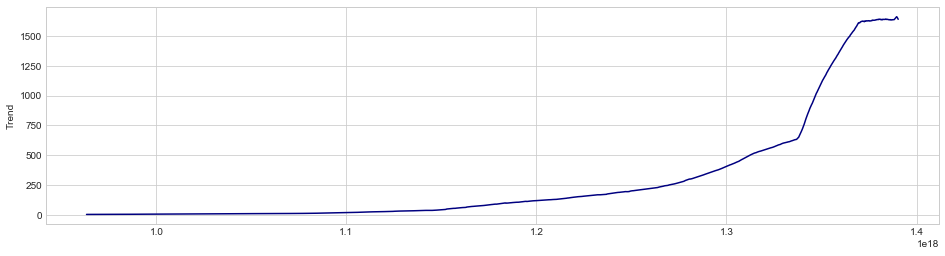

In [94]:
#trend
ev2= df.groupby(['reviewTime']).mean()
ev2['number_reviews']=df.groupby(['reviewTime']).count().asin
ev2.year=list(map(lambda x:int(x) , ev2.year))
variable='number_reviews'
data2=pd.Series(ev2[variable])
res3 = seasonal_decompose(data2,freq=365)
plt.figure(figsize=(16,4))
plt.plot(res3.trend,'navy')
plt.ylabel('Trend')
plt.savefig("4_trend.png")

In this part, we only treat the 2007-2011 interval:
Indeed, the 1996-2007 interval doesn't have enough observations to study the series, and the 2012-2014 interval is too short to observe a yearly pattern.

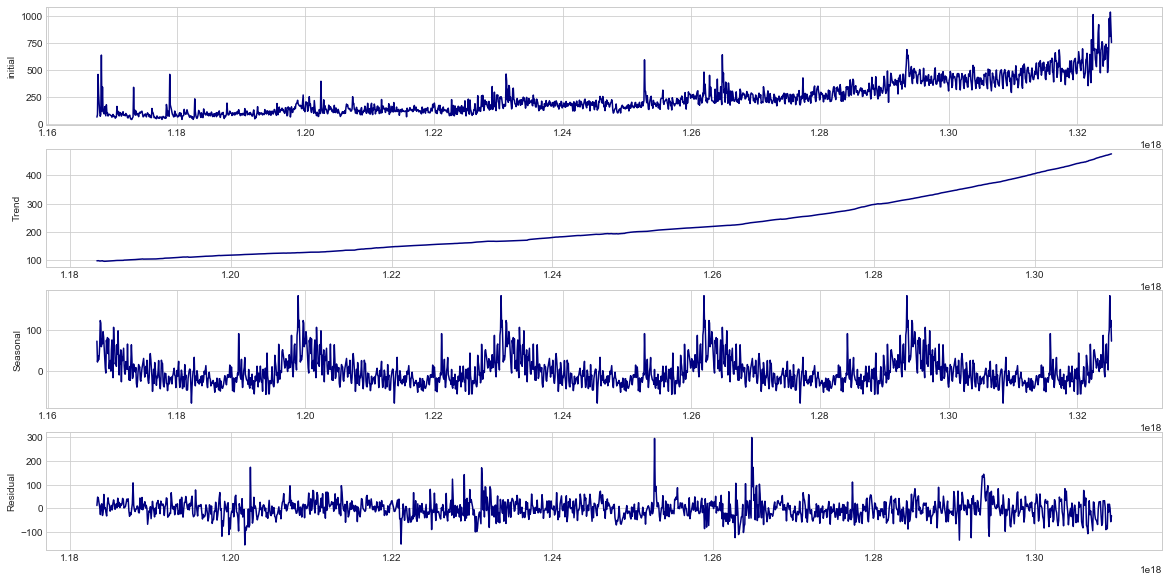

In [78]:
#seasonal decomposition
df1=df[(df.year>2006)&(df.year<2012)]
ev1= df1.groupby(['reviewTime']).mean()
ev1['number_reviews']=df1.groupby(['reviewTime']).count().asin
ev1.year=list(map(lambda x:int(x) , ev1.year))
variable='number_reviews'
data1=pd.Series(ev1[variable])
res1 = seasonal_decompose(data1,freq=365)
plt.figure(figsize=(20,10))
plt.subplot(4,1,1)
plt.plot(res1.observed,'navy')
plt.ylabel('initial')
plt.subplot(4,1,2)
plt.plot(res1.trend,'navy')
plt.ylabel('Trend')
plt.subplot(4,1,3)
plt.plot(res1.seasonal,'navy')
plt.ylabel('Seasonal')
plt.subplot(4,1,4)
plt.plot(res1.resid,'navy')
plt.ylabel('Residual')
plt.savefig("3_seasonal_decomposition.png")

In the graph above, we see a clear increasing trend. We also observe a yearly seasonality, with a peak around December and January and a smaller peak around November.
In order to check wether there is another seasonality in our data, we apply the decomposition again on the residual,this time with a 7-day period.

In [18]:
res2=seasonal_decompose(res1.resid.dropna(),freq=7)

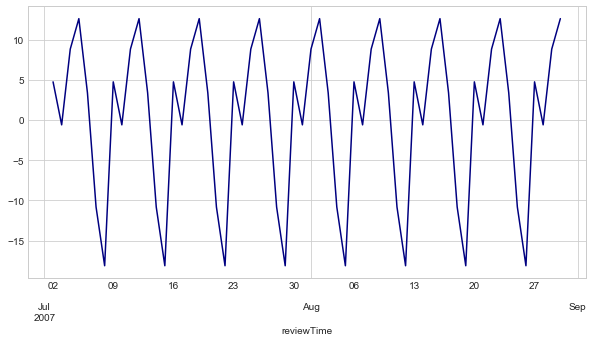

In [19]:
plt.figure(figsize=(10,5))
res2.seasonal[0:60].plot(color='navy')
plt.savefig("4_zoom_weekly_pattern.png")

### Number of reviews by sub-categories 
In this part, we check wether all the sub-categories follow the same pattern.

In [34]:
evolution= df.groupby(['sub_category_1','reviewTime']).median()
evolution['number_reviews']=df.groupby(['sub_category_1','reviewTime']).count().asin
evolution.year=list(map(lambda x:int(x) , evolution.year))


After ploting the timeline for all the sub-categories, we notice that the size of some of them is too small to give readable plots. We will then restrict ourselves to the 4 largest categories, which we select below.

In [35]:

categories=list(set(df.sub_category_1))
categories=['Computers & Accessories' , 'Accessories & Supplies' , 'Camera & Photo' , 'Portable Audio & Video']
colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']


In [36]:
def compare_timeline(p,variable,category,c='navy'):
    data=evolution.loc[category,variable]
    avg=data.rolling(15,center=True).median()
    
    p.line(data.index.values,avg,color=c,legend=str(category))
    p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='%Y',months='%B')
    return p

In [39]:

p = figure(width=750, height=400, x_axis_type="datetime",tools=[])
output_notebook()
i=0
for cat in categories:
    p=compare_timeline(p,'number_reviews',str(cat),c=colors[i])
    i=i+1
p.title.text='Evolution of the median daily number of reviews' 
p.legend.location = "top_left"
p.grid.grid_line_alpha=0
p.xaxis.axis_label = 'Date'
show(p)
output_file('5_Comparison_number_review_categories.html', title='5_Comparison_number_review_categories.html')


Loading BokehJS ...

We are interested in seeing how some characteristics of the reviews evolved through the years .
### Length of the reviews 

In [62]:
#length of the reviews 
hover=HoverTool(tooltips=[( 'Year',   '@year'),( 'Length of reviews',  '@length_review' ),('number of reviews','@number_reviews'),],)
p = figure(width=750, height=400, x_axis_type="datetime",tools=[hover,'pan','wheel_zoom','box_zoom','reset'])
p=timeline_electronics(p,'length_review','Daily Median Length of the Reviews','orange')
show(p)
output_file('6_Length_reviews.html', title='Length_reviews')


Loading BokehJS ...

### Sentiment of the reviews

In [63]:
#sentiment of the reviews
hover=HoverTool(tooltips=[( 'Year',   '@year'),( 'positiveness of reviews',  '@sentiment_pos'),('negativeness of reviews','@sentiment_neg'),('number of reviews','@number_reviews') ,],)
p = figure(width=750, height=400, x_axis_type="datetime",tools=[])

p=timeline_electronics(p,'sentiment_pos','Daily Median Sentiment Scores of the Reviews','green')
p=timeline_electronics(p,'sentiment_neg','Daily Median Sentiment Scores of the Reviews','red')
show(p)
output_file('7_sentiment_evolution.html', title='sentiment_evolution')


Loading BokehJS ...

Loading BokehJS ...

### Overall Score

In [64]:
#overall score
hover=HoverTool(tooltips=[( 'Year',   '@year'),( 'Overall score',  '@overall'),('number of reviews','@number_reviews') ,],)
p = figure(width=750, height=400, x_axis_type="datetime",tools=[hover,'pan','wheel_zoom','box_zoom','reset'])
p=timeline_electronics(p,'overall','Daily Median Overall Score of the Products','orange')
show(p)
output_file('8_Overall_evolution.html', title='Overall_evolution')


Loading BokehJS ...

We notice that the overall score and the positivity score follow roughtly the same pattern.

## 5- Variable Distributions & Correlations

In this section, we will study the distribution of the variables of interest, first at the level of the whole 'Electronics' dataset, then at the level of the 4 main sub-categories.
For this purpose, we will focus on the 2013-2014, as we suppose that the prices collected in the metadata only apply for recent dates.

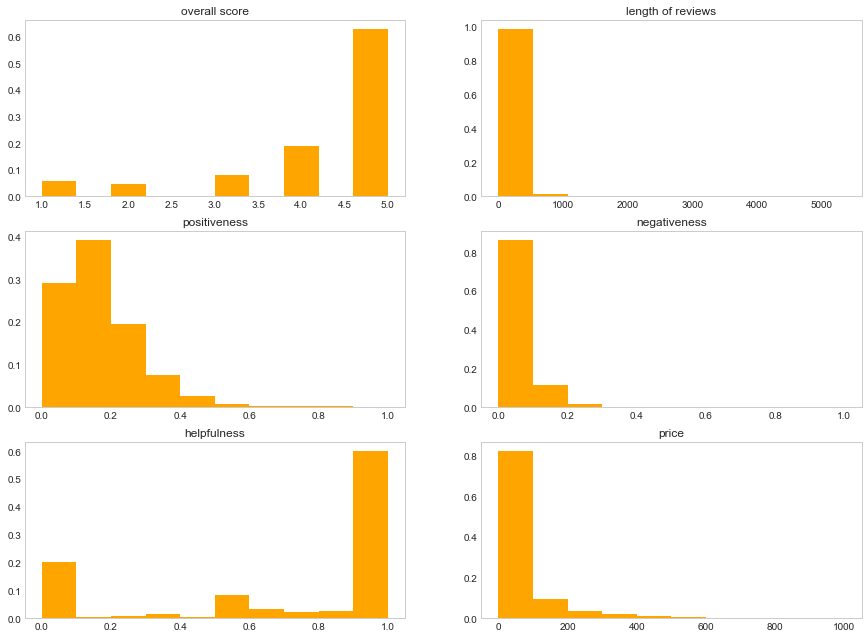

In [49]:
# select the data from 2013-2014
data=df.loc[df.year>2013,['overall','helpfulness','length_review','sentiment_pos','sentiment_neg','price']]

#plot the histograms of the variables
plt.figure(figsize=(15,11))   
plt.subplot(3,2,1)
w= np.ones_like(data['overall'])/float(len(data['overall']))
plt.hist(data['overall'],weights=w,color='orange')
plt.title('overall score')
plt.grid()

plt.subplot(3,2,2)
w= np.ones_like(data.length_review)/float(len(data.length_review))
plt.hist(data['length_review'],weights=w,color='orange')
plt.grid()
plt.title('length of reviews')

plt.subplot(3,2,3)
w= np.ones_like(data.sentiment_pos)/float(len(data.sentiment_pos))
plt.hist(data['sentiment_pos'],weights=w,color='orange')
plt.grid()
plt.title('positiveness')

plt.subplot(3,2,4)
w= np.ones_like(data.sentiment_neg)/float(len(data.sentiment_neg))
plt.hist(data['sentiment_neg'],weights=w,color='orange')
plt.grid()
plt.title('negativeness')

plt.subplot(3,2,5)
w= np.ones_like(data.helpfulness.dropna())/float(len(data.helpfulness.dropna()))
plt.hist(data['helpfulness'].dropna(),weights=w,color='orange')
plt.grid()
plt.title('helpfulness')

plt.subplot(3,2,6)
w= np.ones_like(data.price.dropna())/float(len(data.price.dropna()))
plt.hist(data['price'].dropna(),weights=w,color='orange')
plt.grid()
plt.title('price')
plt.savefig('distribution_Variables.png')


## Remarks : 

- More than 60% of the products have a 5 stars rating and very few of them are rated negatively (less than 2 stars)
- Almost all the reviews are less than 500 words long, but there are still some reviews that are extremely long.
- the positivity and negativity scores are low in general. However, we can say that the positivity scores tend to be slightly higher.(80% of the negativity scores are less than 0.1).
- We have already noticed that most of the reviews are not rated for their helpfulness (260881 over 341188).However those who get rated, have a high helpfulness score.Of course, this score doen't take into account the number of people that actually voted so a review can have the maximum score 1, even if only 1 person actually voted and found it helpful.
- Finally, most of the reviewed products are less than 100 dollars and the maximum price in the electronics category is 1000 dollars.

Now, we want to check whether there is strong correlation between these variables. We start with a basic correlation matrix.

In [76]:
import itertools
def plot_correlation_matrix(cm, classes,title='Correlation matrix', cmap=plt.cm.RdBu):
    normalize=False
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.clim(-1,1)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             
np.set_printoptions(precision=2)

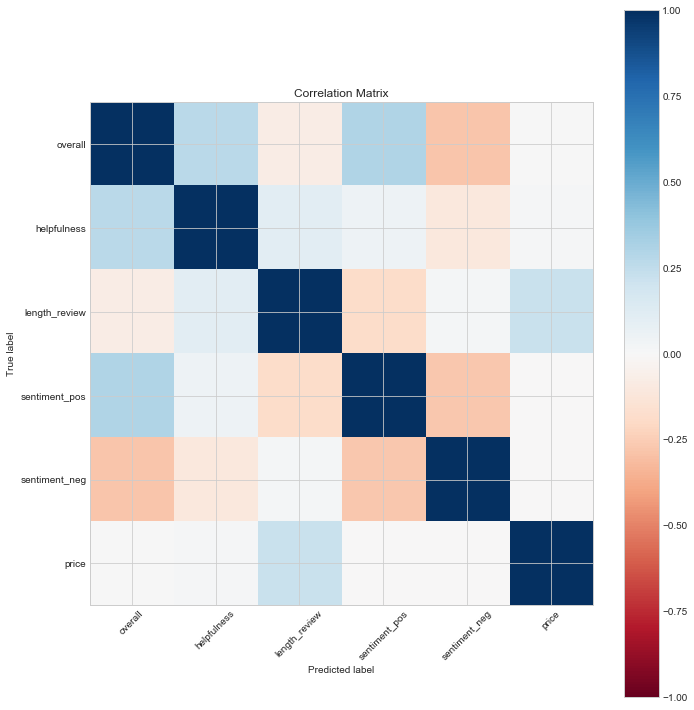

In [70]:
#correlation matrix 
cm=data.corr()
plt.figure(figsize=(10,10))
plot_correlation_matrix(cm, classes=data.columns,title='Correlation Matrix')
plt.show()   
plt.savefig('correlation_matrix.png')

Overall, there is no appearent correlations between the variables. What about their distribution across the different sub-categories?

In [71]:
score=df[['sub_category_1','overall','length_review','price','sentiment_com','sentiment_pos','sentiment_neg','helpfulness']].groupby('sub_category_1').agg(['mean','std'])
score=score.iloc[[1,2,7,14]]

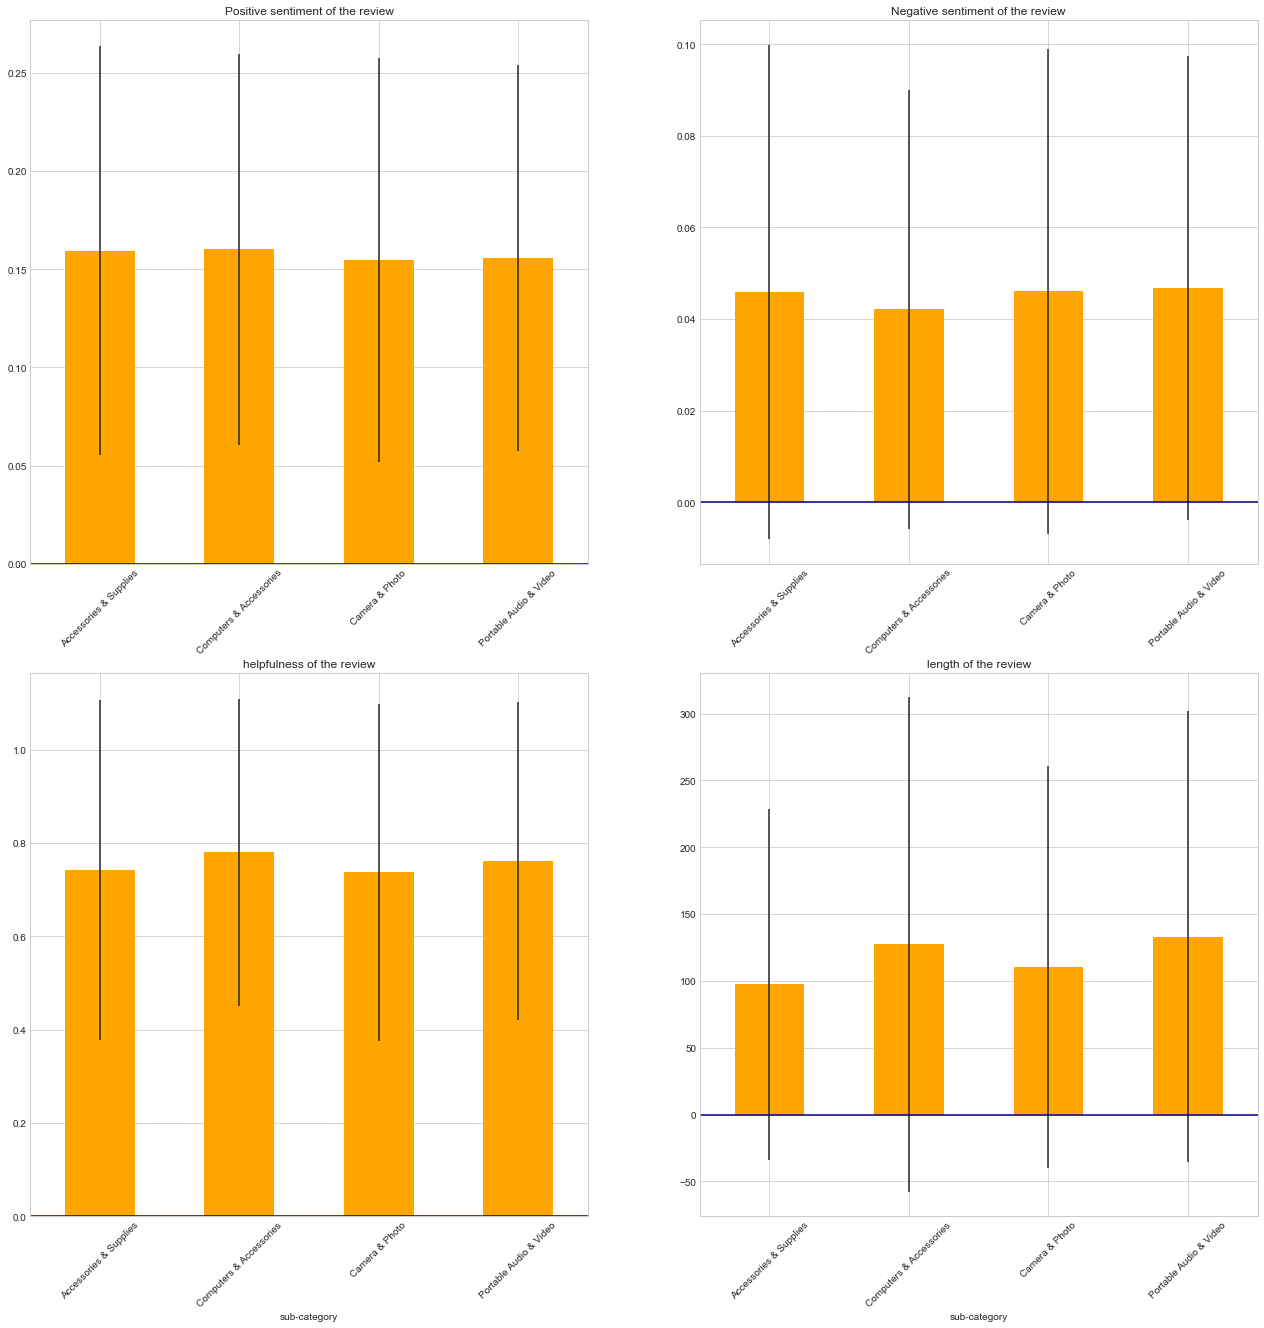

In [78]:
categories=['Accessories & Supplies' , 'Computers & Accessories','Camera & Photo' , 'Portable Audio & Video']


plt.figure(figsize=(22,22))
plt.subplot(2,2,1)
score['sentiment_pos']['mean'].plot.bar(yerr=score['sentiment_pos']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('Positive sentiment of the review')
plt.xlabel('')
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)

plt.subplot(2,2,2)
score['sentiment_neg']['mean'].plot.bar(yerr=score['sentiment_neg']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('Negative sentiment of the review')
plt.xlabel('')
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.subplot(2,2,3)
score['helpfulness']['mean'].plot.bar(yerr=score['helpfulness']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('helpfulness of the review')
plt.xlabel('sub-category')
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.subplot(2,2,4)
score['length_review']['mean'].plot.bar(yerr=score['length_review']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('length of the review')
plt.xlabel('sub-category')
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.savefig('distribution_across_categories.png')

We observe that the mean value of all the variable is roughtly the same across the 4 main categories.However the large standard deviation indicates that the within-category variance is very large. 

In this last part, we group the review according to the overall score and see whether the mean values of the variables are different in each group.

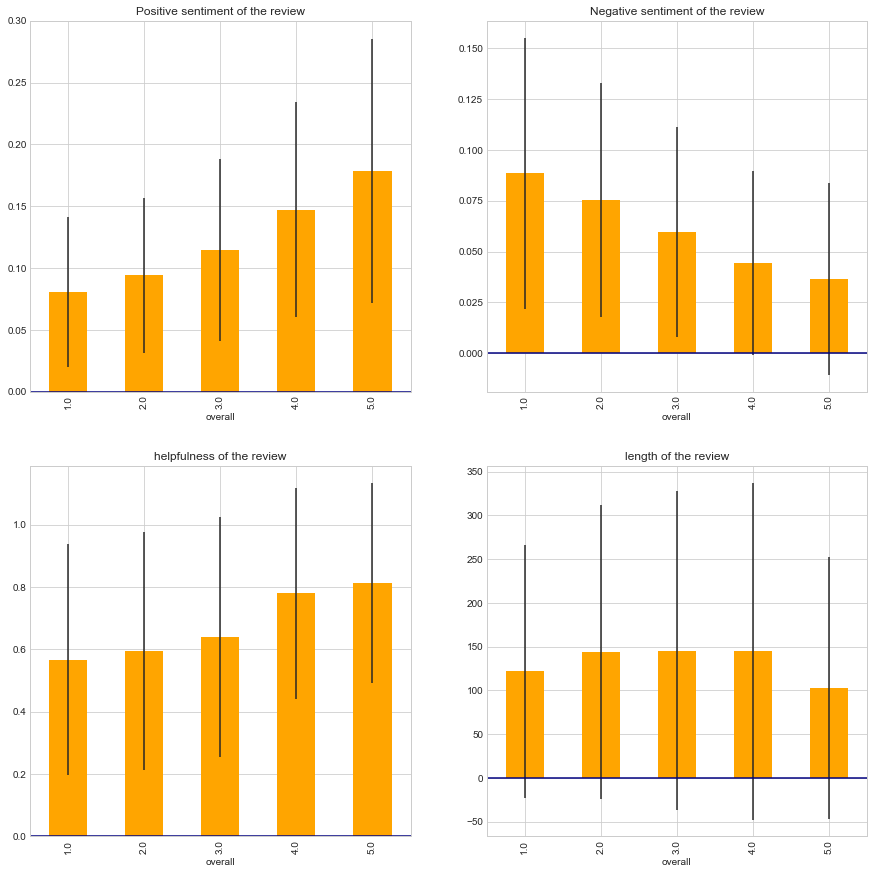

In [79]:
sc_overall=df.groupby('overall').agg(['mean','std'])
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sc_overall['sentiment_pos']['mean'].plot.bar(yerr=sc_overall['sentiment_pos']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('Positive sentiment of the review')
plt.subplot(2,2,2)
sc_overall['sentiment_neg']['mean'].plot.bar(yerr=sc_overall['sentiment_neg']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('Negative sentiment of the review')
plt.subplot(2,2,3)
sc_overall['helpfulness']['mean'].plot.bar(yerr=sc_overall['helpfulness']['std'],color='orange')
plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('helpfulness of the review')
plt.subplot(2,2,4)
sc_overall['length_review']['mean'].plot.bar(yerr=sc_overall['length_review']['std'],color='orange')

plt.axhline(y=0, xmin=0, xmax=1, hold=None,color='navy')
plt.title('length of the review')
plt.savefig('distribution_overall.png')

Although it looks like the sentiment scores follow the same trend as the overall score -which corresponds to our initial intuition, we have to note that the number of reviews in each group is different and the variance within the group is too large to  assert with confidence that there is a strong connection.